In [1]:
using Turing
using AbstractGPs
using FillArrays
using LaTeXStrings
using Plots
using RDatasets
using ReverseDiff
using StatsBase

using LinearAlgebra
using Random
using CSV ,DataFrames

In [1]:
using Turing
using AbstractGPs
using FillArrays
using LaTeXStrings
using Plots
using RDatasets
using ReverseDiff
using StatsBase

using LinearAlgebra
using Random

Random.seed!(1789);

In [42]:
using Distances

In [7]:
using Turing: Variational

In [2]:
begin
    data=CSV.read("w2021-1.csv",DataFrame,header=6)
    data0=CSV.read("w2022-1.csv",DataFrame,header=6)
    data1=CSV.read("w2020.csv",DataFrame,header=6)
    dataset2021=Array(transpose(Matrix(data[1:365,[5]])))
    dataset2022=Array(transpose(Matrix(data0[1:365,[5]])))
    dataset2020=Array(transpose(Matrix(data1[1:365,[4]])))
end

1×365 Matrix{Float64}:
 10.2  11.3  12.0  12.2  10.2  12.2  …  14.0  11.8  12.7  13.5  13.1  12.3

In [3]:
x0=Array(transpose(dataset2020[1:364]))
y0=Array(transpose(dataset2020[2:365]))
x1=Array(transpose(dataset2021[1:364]))
y1=Array(transpose(dataset2021[2:365]))
x2=Array(transpose(dataset2022[1:364]))
y2=Array(transpose(dataset2022[2:365]))

1×364 Matrix{Float64}:
 7.9  10.5  12.4  8.7  2.6  8.4  9.5  …  11.4  12.3  11.9  13.7  11.8  10.5

In [4]:
linear_kernel(α) = LinearKernel() ∘ ARDTransform(α)
sekernel(α) =SqExponentialKernel() ∘ ARDTransform(α);

In [123]:
# Squared-exponential covariance function
sqexp_cov_fn(D, phi, eps=1e-3) = exp.(-D^2 / phi) + LinearAlgebra.I * eps

# Exponential covariance function
exp_cov_fn(D, phi) = exp.(-D / phi)

@model function GP(y, X, m=0, s=1, cov_fn=exp_cov_fn)
    # Dimensions of predictors .
    N, P = size(X)
    
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X, dims=1)
    
    # Priors.
    mu ~ Normal(m, s)
    sig2 ~ LogNormal(0, 1)
    phi ~ LogNormal(0, 1)
    
    # Realized covariance function
    K = cov_fn(D, phi)
   
    
    # Sampling Distribution.
    # The latent variables have been marginalized out here,
    # so there's only one layer. Note that when N is large,
    # this model will be really slow. There are several ways to speed up.
    # 1. Use a low-rank approximation (e.g. predictive process).
    #    This can scale to potentially N=50000. Haven't tried it myself, but I 
    #    believe this shuold be doable in Turing.
    # 2. GP for Big Data: https://arxiv.org/abs/1309.6835
    y ~ MvNormal(mu * ones(N), K + sig2 * LinearAlgebra.I(N))
end
     

GP (generic function with 5 methods)

In [ ]:
cholesky(K + 1e-6 * I)

In [5]:
@model function GPLVM(x,y, K)
    # Dimensionality of the problem.
    N, D = size(x)
    # K is the dimension of the latent space
    @assert K <= D
    noise = 1e-3
    # Priors
    α ~ MvLogNormal(MvNormal(Zeros(K), I))
    σ ~ LogNormal(0.0, 1.0)
    #Z ~ filldist(Normal(), K, N)
    #mu ~ filldist(Normal(), N)
    kxx=GP(sekernel(α))(ColVecs(x1),noise)

    #y ~ filldist(MvNormal(mean(kxx), (cov(kxx)+1e-6 * I)+σ*I), D)
    y ~ MvNormal(mean(kxx), (cov(kxx)+1e-6 * I)+σ*I)
    return nothing
end;

In [5]:
@model function GPLVM(x,y, K)
    n,d=size(x)
    noise = 1e-3
    α ~ MvLogNormal(MvNormal(Zeros(K), I))
    σ ~ LogNormal(0.0, 1.0)
    mu~Normal(0.0,1.0)

    kxx=GP(sekernel(α))(ColVecs(x1),noise)
    y ~ MvNormal(mu*ones(d), (cov(kxx)+1e-6 * I)+σ*I)
    return nothing
end;

In [ ]:
@model function GPLVM(x,y, K)
    noise = 1e-3
    α ~ MvLogNormal(MvNormal(Zeros(K), I))
    σ ~ LogNormal(0.0, 1.0)
    kxx=GP(sekernel(α))(ColVecs(x1),noise)
    y ~ MvNormal(mean(kxx), (cov(kxx)+1e-6 * I)+σ*I)
    return nothing
end;

In [6]:
gplvm = GPLVM(x1,vec(y1),1)
chain_gplvm = sample(gplvm, HMC(0.01, 100), 500);

Sampling: 100%|█████████████████████████████████████████| Time: 0:12:35


In [7]:
using StatsPlots

In [ ]:
chain_gplvm

In [ ]:
plot(chain_gplvm)

In [8]:
a = group(chain_gplvm, :α ).value.data[:, :, 1];

In [9]:
sig2 = group(chain_gplvm, :σ).value.data[:, :, 1];

In [10]:
mu = group(chain_gplvm, :mu).value.data[:, :, 1];

In [13]:
Z=[x1 x2]

1×728 Matrix{Float64}:
 10.5  10.8  8.4  11.4  10.0  6.8  …  13.1  11.4  12.3  11.9  13.7  11.8

In [14]:
kxx(α,x)=GP(sekernel(α))(x);

In [15]:
function new(x,xnew,y,kxx,a,sig,mu)
    pre=kxx(a,x) 
    pre1=kxx(a,[x xnew])
    kk=cov(pre1)
    kno=kk[1:364,365:end]
    c=inv(kk[365:end,365:end]+sig*I)
    m=mu*ones(364).+kno*c*(y'.-mu)
    s=kno.-kno*c*kno'
    return (m,s)
    
 end

new (generic function with 1 method)

In [25]:
function new(x,xnew,y,kxx,mu,sig)
   pre=kxx(mu,x) 
   pre1=kxx(mu,[x xnew])
   kk=cov(pre1)
   kno=kk[1:364,365:end]
   c=inv(kk[365:end,365:end]+sig*I)
   m=mean(pre).+kno*c*(y'-mean(pre))
   s=kno.-kno*c*kno'
   return (m,s)
   
end

new (generic function with 1 method)

In [16]:
nkk=[new(x1,x2,y1,kxx,[a[i]],sig2[i],mu[i]) for i in 1:length(mu)]

500-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;], [0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; … ; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942])
 ([8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;], [0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; … ; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942; 0.9999999999999942 0.9999999999999942 … 0.9999999999999942 0.9999999999999942])
 ([8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;], [0.9999999999999942 0.9999999999999942 … 0.999999

In [ ]:
nkk=[new(x1,x2,y1,kxx,[a[i]],sig2[i],mu[i]) for i in 1:length(mu)]

In [17]:
mm=[nkk[i][1]  for i in 1:length(nkk)];
ss=[nkk[i][2]  for i in 1:length(nkk)];

In [35]:
mm[1:20]

20-element Vector{Matrix{Float64}}:
 [8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;]
 [8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;]
 [8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;]
 [8.32983540646187; 8.32983540646187; … ; 8.32983540646187; 8.32983540646187;;]
 [4.123062362705081; 4.123062362705081; … ; 4.123062362705081; 4.123062362705081;;]
 [2.8613508412543744; 2.8613508412543744; … ; 2.8613508412543744; 2.8613508412543744;;]
 [3.2375626394996595; 3.2375626394996595; … ; 3.2375626394996595; 3.2375626394996595;;]
 [3.475798162417253; 3.4757981624175516; … ; 3.475798162415547; 3.4757981624206864;;]
 [6.084583962948223; 6.084583962904142; … ; 6.084583962914186; 6.0845839628940706;;]
 [13.676059559451106; 13.676059559451115; … ; 13.676059559451062; 13.6760595594512;;]
 [7.828612068928582; 7.828612069143489; … ; 7.8286120677184465; 7.828612071463418;;]
 [7.828612068928582; 7.828612069143489; … 

In [104]:
diag(mean(ss))

364-element Vector{Float64}:
  0.09503080978279305
  0.08649185077324718
  0.1461420024801013
  0.11673212720960055
  0.1283770745765451
  0.1336628853000976
  0.028341581325330205
  0.18438809773819578
  0.052691560053331796
  0.16429192442112925
  0.2253106961660247
  0.2202446263159062
  0.11061905442646003
  ⋮
  0.13849695124727057
  0.1134505415344987
 -0.016563156519939157
  0.07508140812995896
  0.006985397995129355
  0.0993096201368664
  0.10713049540042903
  0.12134554081257203
  0.09261988346557157
  0.11667549116176282
  0.04967772466220061
  0.07658501929128411

In [34]:
mean(ss)

364×364 Matrix{Float64}:
  0.0950308    0.0961628   0.163969  …  0.130454    0.100811   0.163691
  0.0856157    0.0864919   0.162717     0.134389    0.110567   0.158732
  0.158503     0.161223    0.146142     0.100724    0.0344007  0.189258
  0.0667611    0.0670832   0.164111     0.142441    0.130022   0.148735
  0.11061      0.112135    0.157726     0.12368     0.084598   0.171265
  0.199499     0.202469    0.132469  …  0.0772246  -0.0105302  0.1976
  0.0266973    0.0256516   0.167898     0.156345    0.171023   0.120647
  0.206271     0.20929     0.129693     0.0729036  -0.018127   0.19813
  0.158503     0.161223    0.146142     0.100724    0.0344007  0.189258
  0.167772     0.170758    0.14375      0.0963044   0.025478   0.19155
  0.206271     0.20929     0.129693  …  0.0729036  -0.018127   0.19813
  0.222634     0.225697    0.122066     0.0616722  -0.0368875  0.198051
  0.0327303    0.0319079   0.167477     0.154557    0.164871   0.125263
  ⋮                                  ⋱      

In [88]:

function quantiles(X, q; dims, drop=false)
    Q = mapslices(x -> quantile(x, q), X, dims=dims)
    out = drop ? dropdims(Q, dims=dims) : Q
    return out
  end

quantiles (generic function with 1 method)

In [43]:
vec(mean(mm))

364-element Vector{Float64}:
 13.396347092049027
 13.533900841276383
 12.598917555439074
 13.826490699806905
 13.180179328335436
 12.182736944447411
 14.538182622993148
 12.122282911252736
 12.598917555439074
 12.508540369507415
 12.122282911252736
 11.986727723841494
 14.421962970183813
  ⋮
 13.180179328335436
 14.087843470712695
 16.17776508862527
 15.026392743475782
 14.839020502581764
 14.839020502581764
 15.415946908933499
 12.370714560389905
 12.508540369507415
 12.98045829273457
 12.762521065951114
 15.68612912226231

In [65]:
ss[1]+1e-6*I(364)

364×364 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [73]:
using Statistics

In [142]:
mvn

FullNormal(
dim: 364
μ: [3.766330792046487, -0.9980790824171388, -2.964758844741252, -2.897630798388908, 1.8254627946625552, 0.004903408402775041, 0.004903408402775041, 0.004903408402775041, -2.964758844741252, -3.595481679355701  …  3.5973255124036503, 0.004903408404046027, 0.004903408417805512, 0.004903408417805512, 0.6505950886675057, 0.004903408378246768, -3.595481679355701, -0.798680273651327, 4.9959269110050375, 0.004903408426914351]
Σ: [5.0523839877154056e14 9.04973004182851e-104 … -1.2152328755543868e-95 -7.887561339835254e-62; 9.04973004182851e-104 5.0523839877154056e14 … -7.089356841399143e-61 -1.3795009172802913e-26; … ; -1.2152328755543868e-95 -7.089356841399143e-61 … 5.0523839877154056e14 -1.7031968837752941e-221; -7.887561339835254e-62 -1.3795009172802913e-26 … -1.7031968837752941e-221 5.0523839877154056e14]
)


In [107]:
ss1=diag(MvNormal(vec(mm[1]),ss[1]+1e-6*I(364)).Σ)

364-element Vector{Float64}:
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 ⋮
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941
 1.0000009999999941

In [128]:
ss2=sqrt.(abs.(diag(sum(ss))))

364-element Vector{Float64}:
  6.8931418737319285
  6.576163424567822
  8.548157768785662
  7.63976855701796
  8.011774914978112
  8.175050009024336
  3.7644110645179416
  9.6017732148337
  5.132814045595836
  9.063440969662937
 10.613922370312133
 10.493917912674613
  7.43703752936813
  ⋮
  8.321566897143548
  7.531618070989085
  2.8777731425478237
  6.127046928576561
  1.8688763997559275
  7.046616923633156
  7.318828301047546
  7.789272777755701
  6.805140831223538
  7.637915002203246
  4.98386018374315
  6.1880941852594695

In [109]:
mn=[Normal(mean(mm)[i],ss1[i]) for i in 1:length(ss1)]

364-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=13.396347092049027, σ=1.0000009999999941)
 Normal{Float64}(μ=13.533900841276383, σ=1.0000009999999941)
 Normal{Float64}(μ=12.598917555439074, σ=1.0000009999999941)
 Normal{Float64}(μ=13.826490699806905, σ=1.0000009999999941)
 Normal{Float64}(μ=13.180179328335436, σ=1.0000009999999941)
 Normal{Float64}(μ=12.182736944447411, σ=1.0000009999999941)
 Normal{Float64}(μ=14.538182622993148, σ=1.0000009999999941)
 Normal{Float64}(μ=12.122282911252736, σ=1.0000009999999941)
 Normal{Float64}(μ=12.598917555439074, σ=1.0000009999999941)
 Normal{Float64}(μ=12.508540369507415, σ=1.0000009999999941)
 Normal{Float64}(μ=12.122282911252736, σ=1.0000009999999941)
 Normal{Float64}(μ=11.986727723841494, σ=1.0000009999999941)
 Normal{Float64}(μ=14.421962970183813, σ=1.0000009999999941)
 ⋮
 Normal{Float64}(μ=13.180179328335436, σ=1.0000009999999941)
 Normal{Float64}(μ=14.087843470712695, σ=1.0000009999999941)
 Normal{Float64}(μ=16.17776508862527, σ=1.000

In [129]:
mn1=[Normal(mean(mm)[i],ss2[i]) for i in 1:length(ss2)]

364-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=13.396347092049027, σ=6.8931418737319285)
 Normal{Float64}(μ=13.533900841276383, σ=6.576163424567822)
 Normal{Float64}(μ=12.598917555439074, σ=8.548157768785662)
 Normal{Float64}(μ=13.826490699806905, σ=7.63976855701796)
 Normal{Float64}(μ=13.180179328335436, σ=8.011774914978112)
 Normal{Float64}(μ=12.182736944447411, σ=8.175050009024336)
 Normal{Float64}(μ=14.538182622993148, σ=3.7644110645179416)
 Normal{Float64}(μ=12.122282911252736, σ=9.6017732148337)
 Normal{Float64}(μ=12.598917555439074, σ=5.132814045595836)
 Normal{Float64}(μ=12.508540369507415, σ=9.063440969662937)
 Normal{Float64}(μ=12.122282911252736, σ=10.613922370312133)
 Normal{Float64}(μ=11.986727723841494, σ=10.493917912674613)
 Normal{Float64}(μ=14.421962970183813, σ=7.43703752936813)
 ⋮
 Normal{Float64}(μ=13.180179328335436, σ=8.321566897143548)
 Normal{Float64}(μ=14.087843470712695, σ=7.531618070989085)
 Normal{Float64}(μ=16.17776508862527, σ=2.8777731425478237)


In [135]:
mean(ss)

364×364 Matrix{Float64}:
  0.0950308    0.0961628   0.163969  …  0.130454    0.100811   0.163691
  0.0856157    0.0864919   0.162717     0.134389    0.110567   0.158732
  0.158503     0.161223    0.146142     0.100724    0.0344007  0.189258
  0.0667611    0.0670832   0.164111     0.142441    0.130022   0.148735
  0.11061      0.112135    0.157726     0.12368     0.084598   0.171265
  0.199499     0.202469    0.132469  …  0.0772246  -0.0105302  0.1976
  0.0266973    0.0256516   0.167898     0.156345    0.171023   0.120647
  0.206271     0.20929     0.129693     0.0729036  -0.018127   0.19813
  0.158503     0.161223    0.146142     0.100724    0.0344007  0.189258
  0.167772     0.170758    0.14375      0.0963044   0.025478   0.19155
  0.206271     0.20929     0.129693  …  0.0729036  -0.018127   0.19813
  0.222634     0.225697    0.122066     0.0616722  -0.0368875  0.198051
  0.0327303    0.0319079   0.167477     0.154557    0.164871   0.125263
  ⋮                                  ⋱      

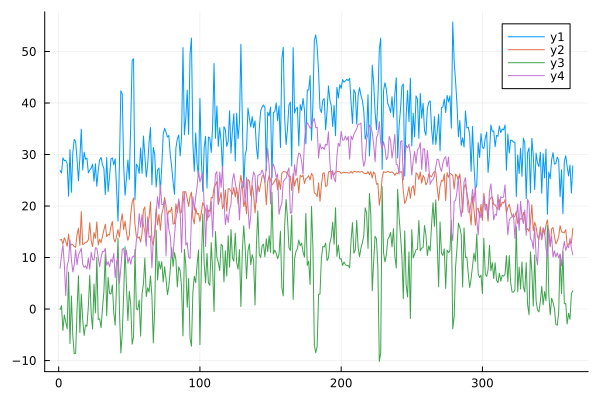

In [130]:
plot(quantile.(mn1,[0.975]))
plot!(mean(mm))
plot!(quantile.(mn1,[0.025]))
plot!(y2')

In [56]:
MvNormal(vec(mean(mm)),Hermitian(sum(ss)))

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

In [29]:
quantile((mm,ss))

LoadError: MethodError: no method matching quantile(::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}})
[0mClosest candidates are:
[0m  quantile(::Any, [91m::Any[39m; sorted, alpha, beta) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/stdlib/v1.7/Statistics/src/Statistics.jl:1070
[0m  quantile([91m::AbstractVector{T} where T<:Real[39m, [91m::AbstractWeights{var"#s30", T} where {var"#s30"<:Real, T<:Real}[39m, [91m::Number[39m) at ~/.julia/packages/StatsBase/XgjIN/src/weights.jl:772
[0m  quantile([91m::AbstractVector{T} where T<:Real[39m, [91m::UnitWeights[39m, [91m::AbstractVector{T} where T<:Real[39m) at ~/.julia/packages/StatsBase/XgjIN/src/weights.jl:767
[0m  ...

In [ ]:
mm=[nkk[i][1]  for i in 1:length(nkk)]

In [ ]:
ss=[nkk[i][2]  for i in 1:length(nkk)]

In [81]:
ktx=GP(sekernel(vec(a)))(ColVecs(Z),1e-3)

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- ARD Transform (dims: 500))
x: SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[[10.5], [10.8], [8.4], [11.4], [10.0], [6.8], [12.7], [6.5], [8.4], [8.1]  …  [9.9], [10.7], [8.4], [11.5], [13.1], [11.4], [12.3], [11.9], [13.7], [11.8]]
Σy: [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]
)


In [82]:
kkk=cov(ktx);
koinv=inv(kkk[365:end,365:end]);
knn=kkk[1:364,1:364];
kno=kkk[1:364,365:end];
c=kno*koinv;
m=c*(y1.-mean(mu))'.+mean(kkk);
s=Matrix(LinearAlgebra.Hermitian(knn-c*kno));
mvn=MvNormal(vec(m),s+ (1e-6)*I+mean(sig2)*I(364))

FullNormal(
dim: 364
μ: [3.766330792046487, -0.9980790824171388, -2.964758844741252, -2.897630798388908, 1.8254627946625552, 0.004903408402775041, 0.004903408402775041, 0.004903408402775041, -2.964758844741252, -3.595481679355701  …  3.5973255124036503, 0.004903408404046027, 0.004903408417805512, 0.004903408417805512, 0.6505950886675057, 0.004903408378246768, -3.595481679355701, -0.798680273651327, 4.9959269110050375, 0.004903408426914351]
Σ: [5.0523839877154056e14 9.04973004182851e-104 … -1.2152328755543868e-95 -7.887561339835254e-62; 9.04973004182851e-104 5.0523839877154056e14 … -7.089356841399143e-61 -1.3795009172802913e-26; … ; -1.2152328755543868e-95 -7.089356841399143e-61 … 5.0523839877154056e14 -1.7031968837752941e-221; -7.887561339835254e-62 -1.3795009172802913e-26 … -1.7031968837752941e-221 5.0523839877154056e14]
)


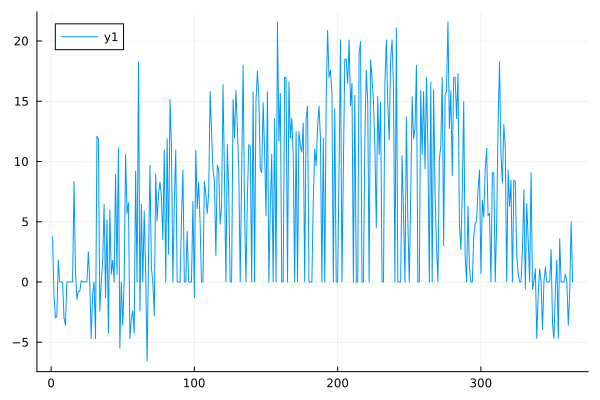

In [84]:
plot(m)

In [ ]:
mean(ss)

In [ ]:
mean(mm)

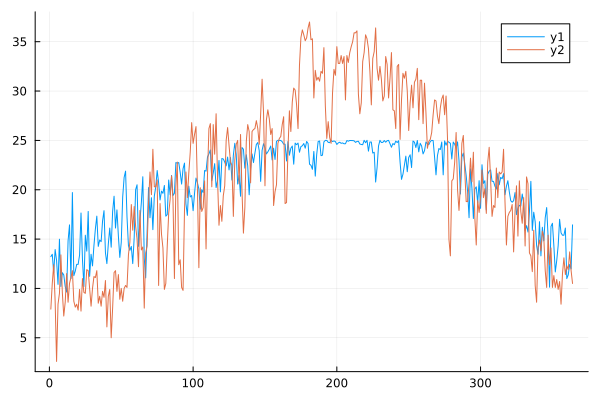

In [61]:
plot(mean(mm))
plot!(y2')

In [106]:
kk=GP(sekernel(vec(mu)))(ColVecs(x1))


AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Euclidean}, ARDTransform{Vector{Float64}}}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Euclidean}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Euclidean(0.0))
	- ARD Transform (dims: 500))
x: SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[[10.5], [10.8], [8.4], [11.4], [10.0], [6.8], [12.7], [6.5], [8.4], [8.1]  …  [15.2], [13.5], [13.2], [13.2], [14.1], [7.6], [8.1], [9.5], [8.9], [14.5]]
Σy: [1.0e-18 0.0 … 0.0 0.0; 0.0 1.0e-18 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-18 0.0; 0.0 0.0 … 0.0 1.0e-18]
)


In [67]:
ktx=GP(sekernel(vec(mu)))(ColVecs(Z))

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- ARD Transform (dims: 500))
x: SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[[10.5], [10.8], [8.4], [11.4], [10.0], [6.8], [12.7], [6.5], [8.4], [8.1]  …  [9.9], [10.7], [8.4], [11.5], [13.1], [11.4], [12.3], [11.9], [13.7], [11.8]]
Σy: [1.0e-18 0.0 … 0.0 0.0; 0.0 1.0e-18 … 0.0 0.0; … ; 0.0 0.0 … 1.0e-18 0.0; 0.0 0.0 … 0.0 1.0e-18]
)


In [71]:
ktx=GP(sekernel(vec(mu)))(ColVecs(Z),1e-3)

AbstractGPs.FiniteGP{GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}, ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Diagonal{Float64, Fill{Float64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: GP{AbstractGPs.ZeroMean{Float64}, TransformedKernel{SqExponentialKernel{Distances.Euclidean}, ARDTransform{Vector{Float64}}}}(AbstractGPs.ZeroMean{Float64}(), Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- ARD Transform (dims: 500))
x: SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}[[10.5], [10.8], [8.4], [11.4], [10.0], [6.8], [12.7], [6.5], [8.4], [8.1]  …  [9.9], [10.7], [8.4], [11.5], [13.1], [11.4], [12.3], [11.9], [13.7], [11.8]]
Σy: [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]
)


In [72]:
kkk=cov(ktx);

In [73]:
koinv=inv(kkk[365:end,365:end]);

In [70]:
knn=kkk[1:364,1:364];
kno=kkk[1:364,365:end];

In [51]:
c=kno*koinv;

In [161]:
mean(kkk)

0.059073630021801625

In [ ]:
kxx=GP(sekernel())(ColVecs(x1),noise)

#y ~ filldist(MvNormal(mean(kxx), (cov(kxx)+1e-6 * I)+σ*I), D)
y ~ MvNormal(mean(kxx), (cov(kxx)+1e-6 * I)+σ*I)

In [52]:
m=c*(y1.-mean(kkk))'.+mean(kkk);

In [62]:
mean(ktx)

728-element Zeros{Float64}

In [63]:
m1=c*(y1')

364×1 Matrix{Float64}:
 15.16279602492109
 14.696328714944322
 11.843000476218089
 12.419523825448756
 13.462160859410027
  7.326686896251486
 17.174195955306764
 11.37060315160631
 11.843000476218089
 11.965249849948218
 11.37060315160631
 14.468674073163502
 16.03043216238854
  ⋮
 13.462160859410027
 11.740084740487521
 17.83851476591134
 15.006052815099764
 16.377397848921365
 16.377397848921365
 14.912877210652379
  9.277294482674073
 11.965249849948218
 11.785545591609969
 13.015335573769189
 14.973418941012

In [59]:
mean(kkk)

0.07069358293940003

In [53]:
s=Matrix(LinearAlgebra.Hermitian(knn-c*kno));

In [54]:
mvn=MvNormal(vec(m),s+ (1e-6)*I+mean(sig2)*I(364))

FullNormal(
dim: 364
μ: [15.162798768418295, 14.696330488350338, 11.843001118479277, 12.41952680006999, 13.4621620395947, 7.327391230792392, 17.174204602883293, 11.371689284897633, 11.843001118479277, 11.965266019696731  …  17.838518819572954, 15.006055386491477, 16.377403341294475, 16.377403341294475, 14.912879291082104, 9.277244234690965, 11.965266019696731, 11.785548378396319, 13.015342100496893, 14.973422640105229]
Σ: [113.18426428556143 0.7180702072947823 … 0.021389447131916414 -0.22422132784313015; 0.7180702072947823 113.17532790292896 … -0.0957762767064498 -0.09603632048475573; … ; 0.021389447131916414 -0.0957762767064498 … 113.1947015104453 -0.42640507654764265; -0.22422132784313015 -0.09603632048475573 … -0.42640507654764265 113.06429690677797]
)


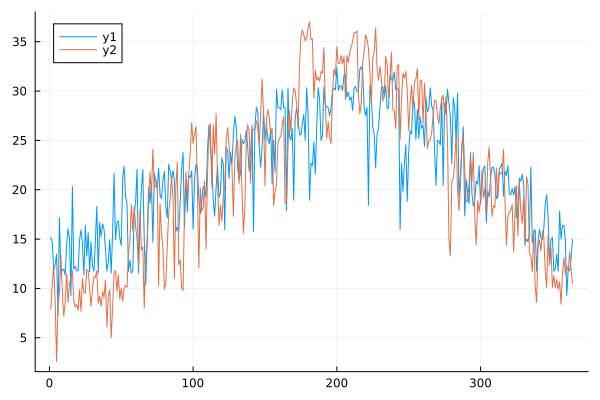

In [66]:
plot(m1)
plot!(y2')

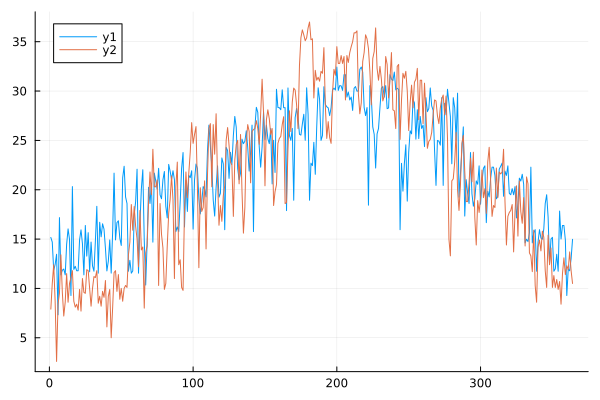

In [56]:
plot(mvn.μ)
plot!(y2')

In [79]:
norm(mvn.μ)

427.44268701503734

In [81]:
norm(y2)

434.289753505652

In [85]:
sum(mvn.μ.*vec(y2))/norm(y2)/norm(mvn.μ)

0.9728972570109158

In [90]:
sum((mvn.μ.-vec(y2)).^2)/364

27.77269883275896

In [78]:
sum(mvn.μ.*y2)/(norm(y2)*norm(mvn.μ))

326.85136469338005

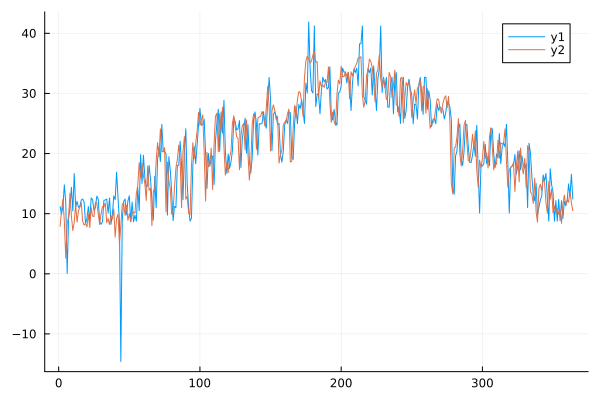

In [285]:
plot(mvn.μ)
plot!(y2')